In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import glob

Populating the interactive namespace from numpy and matplotlib
22050


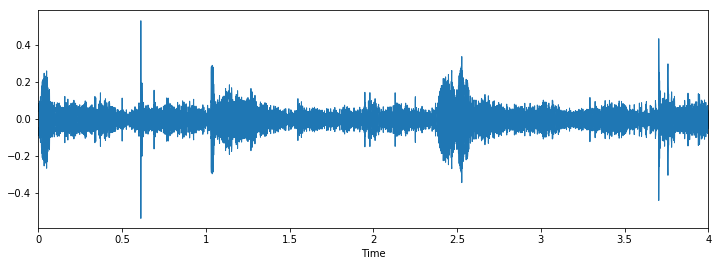

In [2]:
% pylab inline

data, sampling_rate = librosa.load('/home/kameswar/Documents/Code/UrbanSounds/data/Train/2022.wav')
print (sampling_rate)

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [5]:
#Variables
data_dir = '/home/kameswar/Documents/Code/UrbanSounds/data'
train_data_dir = '/home/kameswar/Documents/Code/UrbanSounds/data/Train/'
train_data_path = '/home/kameswar/Documents/Code/UrbanSounds/data/train.csv'
test_data_path = '/home/kameswar/Documents/Code/UrbanSounds/data/test.csv'

In [6]:
train = pd.read_csv(train_data_path)
print (train.shape)

(5435, 2)


Class:  street_music


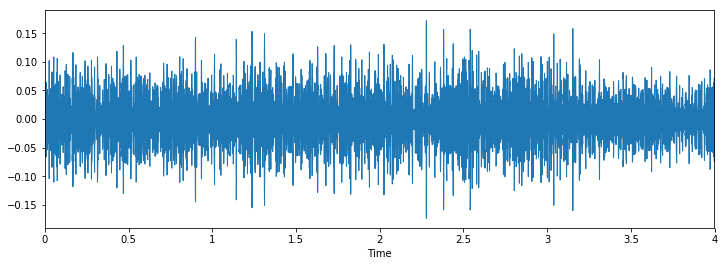

In [7]:
i = random.choice(train.index)

audio_name = train.ID[i]
path = os.path.join(data_dir, 'Train', str(audio_name) + '.wav')

print('Class: ', train.Class[i])
x, sr = librosa.load(train_data_dir + str(train.ID[i]) + '.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)

In [8]:
train.Class.value_counts()

jackhammer          668
engine_idling       624
siren               607
air_conditioner     600
drilling            600
street_music        600
dog_bark            600
children_playing    600
car_horn            306
gun_shot            230
Name: Class, dtype: int64

In [9]:
test = pd.read_csv(test_data_path)
test['Class'] = 'jackhammer'
test.to_csv('sub01.csv', index=False)

In [17]:
#Step 1 and  2 combined: Load audio files and extract features
def parser(row):
   # function to load files and extract features
   file_name = os.path.join(os.path.abspath(data_dir), 'Train', str(row.ID) + '.wav')

   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file_name)
      return None, None
 
   feature = mfccs
   label = row.Class
 
   return [feature, label]

temp = train.apply(parser, axis=1)
temp.columns = ['feature', 'label']

In [16]:
print(temp)
print(temp.feature)

0       [[-82.12358939071989, 139.5059159813099, -42.4...
1       [[-15.744005405358058, 124.1199599305049, -29....
2       [[-123.39365145003913, 15.181946313102896, -50...
3       [[-213.27878814908152, 89.32358896182457, -55....
4       [[-237.92647882472895, 135.90246127730546, 39....
5       [[-250.35704278618198, 128.01181557087781, -47...
6       [[-203.97553041599923, 83.95814057767474, -66....
7       [[-55.40055461612478, 22.767318943295965, -46....
8       [[-110.22915733719984, 91.25898699199308, -137...
9       [[-337.7600192890491, 140.77517821184472, -15....
10      [[-182.77830877917827, 168.22353311947717, 19....
11      [[-178.8089051222893, 174.4008742877636, -30.2...
12      [[-542.225972382311, 21.42193871586533, 4.1834...
13      [[-103.05681746998823, 164.8461568446992, -15....
14      [[-192.07228171960455, 132.0900612528469, -98....
15      [[-199.5289834925619, 183.66896876139222, -7.1...
16      [[-363.9006712951405, 176.40639585192116, 42.3...
17      [[-315

AttributeError: 'Series' object has no attribute 'feature'

In [13]:
#Step 3: Convert the data to pass it in our deep learning model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

/home/kameswar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


AttributeError: 'Series' object has no attribute 'feature'

In [ ]:
#Step 4: Run a deep learning model and get results
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit(X, y, batch_size=32, epochs=5, validation_data=(val_x, val_y))